In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')




from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:


class bikeSales:
    
    
    file = 'clean_sport2.csv'
    df = None
    scaled_df = None
    model = {'Mode': None,
             'Features': [],
             'Score': 0}
    
    
    
    
    def read_data(self):
        df = pd.read_csv(self.file,
                         parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                         infer_datetime_format=True)
        self.df = df
        return


    def add_dummy_variables(self, categorical_features=None):
        
        if (categorical_features == None):
            categorical_features = self.df.select_dtypes(exclude='number').columns
            
        additional = pd.get_dummies(self.df[categorical_features])
        self.df[additional.columns] = additional
        
        self.df.drop(categorical_features, axis=1, inplace=True)
        return

    def feature_plot(model,X,top=10):

        feats_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['FeatureImportance'])
        feats_imp = feats_imp.sort_values('FeatureImportance', ascending=False)[:top]

        feats_imp.plot(kind='barh', figsize=(12,6), legend=False)
        plt.title('Feature Importance from XgBoost Classifier')
        sns.despine(left=True, bottom=True)
        plt.gca().invert_yaxis()
        return

    def plot_accuracy_predictions(self, y_test, pred):
        fig, ax = plt.subplots(figsize=(12,10))
        ax.scatter(y_test,pred)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('Accuracy of Predictions')
        return
    
    
    def scale_data(self, target='Price'):
        local_df = self.df.select_dtypes(include='number')

        features = list(set(local_df.columns) - set([target]))

        sc = StandardScaler()
        sc.fit(self.df[features])
        s = sc.transform(self.df[features])
        self.scaled_df = pd.DataFrame(s,columns=features)

        return
    
    
    def adjusted_r2(self, r2, n, k):
        return 1 - (1-r2)*((n-1)/(n-k-1)) 


    def find_best_model(self, features, y, scaled=False):
        
        self.model['Features'] = features
        X = self.df[features]
        y = self.df['Price']
        
        if scaled == True:
            X = self.scaled_df[features]
            

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

        best_score = 0
        models = []

        models.append(("LassoCV",LassoCV(cv=5)))
        models.append(("LinearRegression",LinearRegression()))
        models.append(("PassiveAggressiveRegressor",PassiveAggressiveRegressor()))
        models.append(("RidgeCV",RidgeCV(cv=5)))
        models.append(("Bagging",BaggingRegressor()))
        models.append(("SVR",SVR()))

        n, k = X_train.shape

        for name, model in models:
            score = cross_val_score(model, X_train, y_train,  cv=5)

            result = self.adjusted_r2(score,n,k)
                    
            if (result.mean() > best_score):
                best_score = result.mean()
                self.model['Model'] = model
                self.model['Score'] = result.mean()
                
        return

    def feature_selection(self, features):
        ## Use Forward Feature Selection to pick a good model
        target = 'Price'
        #features = list(set(self.df.columns) - set([target]))
        X = self.df[features]
        y = self.df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

        # start with no predictors
        included = []
        # keep track of model and parameters
        best = {'feature': '', 'r2': 0, 'a_r2': 0}
        # create a model object to hold the modelling parameters
        model = self.model['Model'] 
        # get the number of cases in the test data
        n = X_test.shape[0]

        while True:
            changed = False

            # list the features to be evaluated
            excluded = list(set(features) - set(included))

            # for each remaining feature to be evaluated
            for new_column in excluded:

                # fit the model with the Training data
                fit = model.fit(X_train[included + [new_column]], y_train) # fit a model; consider which predictors should be included
                # calculate the score (R^2 for Regression)
                r2 = model.score(X_test[included + [new_column]], y_test) # calculate the score
                # number of predictors in this model
                k = len(included + [new_column]) + 1
                # calculate the adjusted R^2
                adjusted_r = self.adjusted_r2(r2,n,k) 


                # if model improves
                if adjusted_r > best['a_r2']:
                    # record new parameters
                    best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r}
                    # flag that found a better model
                    changed = True

            # if found a better model after testing all remaining features
            if changed:
                # update control details
                included.append(best['feature'])
                excluded = list(set(excluded) - set(best['feature']))
                print(f'Added feature: {best["feature"]} with adjusted R^2 = {best["a_r2"]:.3}')
            else:
                # terminate if no better model
                break

        print('')
        print('Resulting features:')
        print(', '.join(included))
        self.model['Features'] = included
        self.model['Score'] = best['a_r2']
        
        return
        
        

    def fit(self, X, y):
        self.model['Model'].fit(X, y)
        return
        
        
    def predict(self, X):
        return self.model['Model'].predict(X)
    
    def deal_type(self):
#         if ('Predicted_Price' not in list(self.df.columns)):
#             raise 
        
        self.df['Price_ratio'] = self.df['Price'] / self.df['Predicted_Price']

        self.df['Deal_type'] = 'Dont Bother'
        self.df['Deal_type'][self.df['Price_ratio'] < 0.9] = 'Negotiate'
        self.df['Deal_type'][self.df['Price_ratio'] < 0.8] = 'Good Deal'
        self.df['Deal_type'][self.df['Price_ratio'] < 0.75] = 'Great Deal'        
        self.df['Deal_type'][self.df['Price_ratio'] < 0.5] = 'Its a steal'
        
#         self.df['Deal_type'][self.df['Price_ratio'] > 1.1] = 'Negotiate'
#         self.df['Deal_type'][self.df['Price_ratio'] > 1.2] = 'Good Deal'
#         self.df['Deal_type'][self.df['Price_ratio'] > 1.5] = 'Great Deal'        
#         self.df['Deal_type'][self.df['Price_ratio'] > 2.0] = 'Its a steal'
        
        return
        
    
    def plot_deals(self,x,y,hue=None,title='',figsize=(12,10)):
        ax = plt.figure(figsize=figsize)
        sns.scatterplot(x=x,y=y,hue=hue,data=self.df);
        plt.title(title,fontsize=14)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #plt.ylim(0,40000)




In [8]:
sport = bikeSales()


In [9]:
sport.read_data()

In [10]:
sport.df.shape

(2593, 64)

In [11]:
sport.add_dummy_variables()

In [7]:
sport.df.shape

(2593, 648)

In [8]:
# sport.scale_data(target='Price')
# sport.scaled_df.describe()

In [ ]:
niave_feature = ['Kilometers','Age']
sport.find_best_model(niave_feature, sport.df['Price'])
print ('Model: ',sport.model['Model'])
print ('Score: ',sport.model['Score'])




Model:  RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
Score:  0.11766300364749702


In [ ]:
sport.fit(sport.df[niave_feature],sport.df['Price'])

predictions = sport.predict(sport.df[niave_feature])



C:\Users\Beau\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
sport.df['Predicted_Price'] = predictions
sport.df[['Price','Predicted_Price']].head()

,Price,Predicted_Price
0,600.0,342.588460
1,1500.0,5475.280827
2,1700.0,9222.247663
3,1900.0,4056.420201
4,1990.0,5634.503168


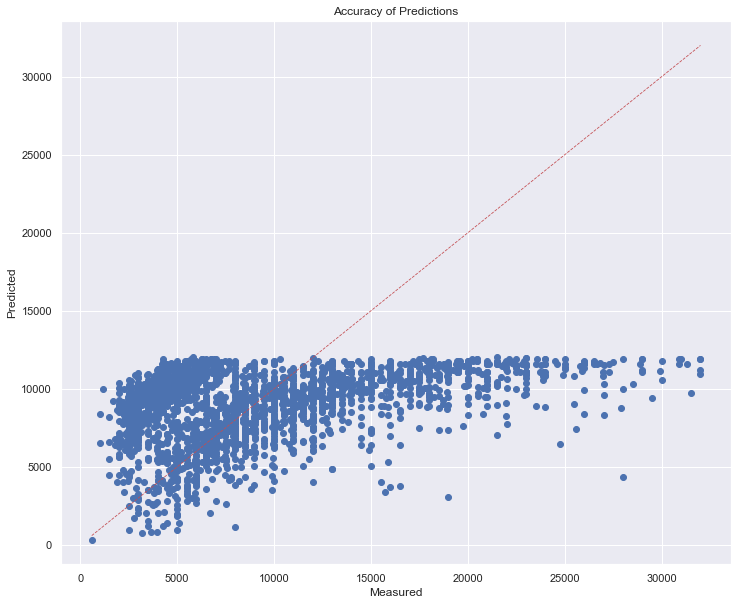

In [ ]:
sport.plot_accuracy_predictions(sport.df['Price'],sport.df['Predicted_Price'])

In [ ]:
sport.deal_type()

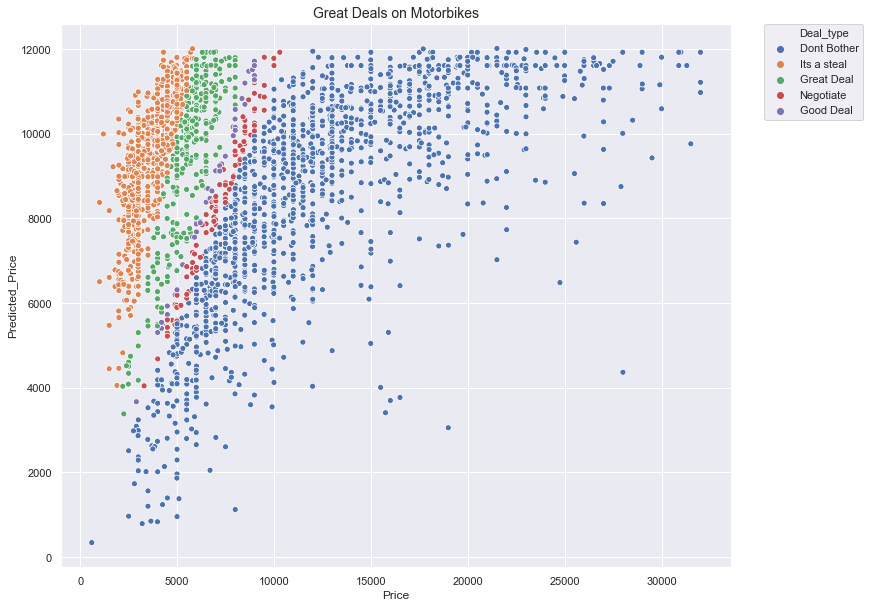

In [ ]:
sport.plot_deals(x='Price',y='Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')


In [ ]:
sport.df.drop(['Predicted_Price','Price_ratio','Deal_type'],axis=1, inplace=True)


In [12]:
bike_cols = [col for col in sport.df.columns if 'Bike' in col]
brand_cols = [col for col in sport.df.columns if 'Brand' in col]
model_cols = [col for col in sport.df.columns if 'Model' in col]
naive_future = ['Kilometers','Age']


In [13]:
def run_pipeline(features=None):
    
    sport = bikeSales()
    sport.read_data()
    sport.add_dummy_variables()
    
    if (features == None):
        features = list(set(sport.df.columns) - set(['Price']))
        
    sport.find_best_model(features, sport.df['Price'])
    print ('Model: ',sport.model['Model'])
    print ('Score: ',sport.model['Score'])

    print ('Feature selection process.')
    sport.feature_selection(features)
    print ('Score: ',sport.model['Score'])
    
    # Optimise model parameters
    
    # Fit the full model
    sport.fit(sport.df[sport.model['Features']],sport.df['Price'])
    # Make predictions
    predictions = sport.predict(sport.df[sport.model['Features']])
    sport.df['Predicted_Price'] = predictions
    
    # Determine the deal type
    sport.deal_type()

    # Display the predicted deals
    sport.plot_deals(x='Price',y='Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')
    
    return sport


Model:  RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
Score:  0.11766300364749702
Feature selection process.
Added feature: Kilometers with adjusted R^2 = 0.123
Added feature: Age with adjusted R^2 = 0.133

Resulting features:
Kilometers, Age
Score:  0.13336712870267797


C:\Users\Beau\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


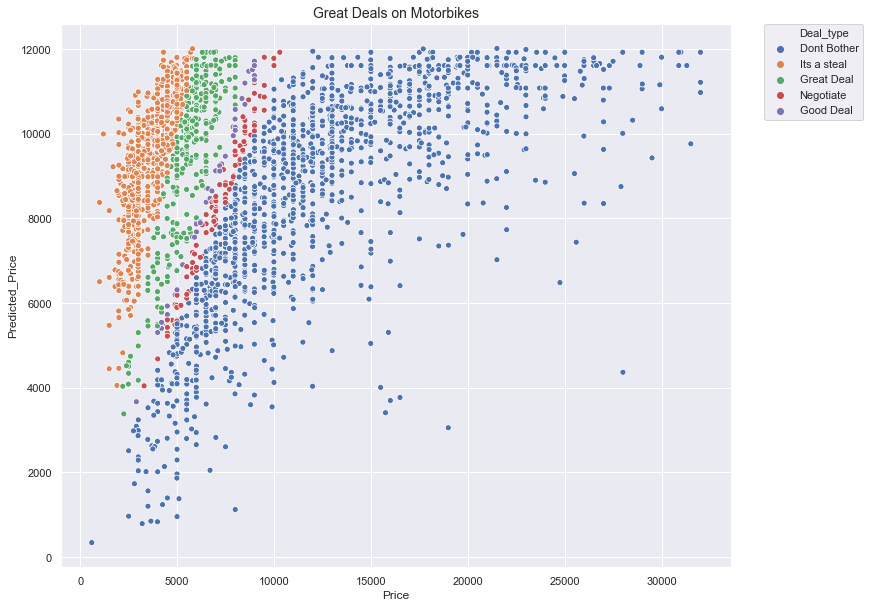

In [ ]:
naive = run_pipeline(naive_feature)

In [ ]:
bikes = run_pipeline(bike_cols)

Model:  RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
Score:  0.7267785182184625
Feature selection process.
Added feature: Bike_S 1000 RR Road Manual 6sp 1000cc with adjusted R^2 = 0.0497
Added feature: Bike_Ninja 250R  Road Manual 6sp 250cc with adjusted R^2 = 0.0905
Added feature: Bike_959 Panigale Road Manual 6sp 959cc with adjusted R^2 = 0.127
Added feature: Bike_1199 Panigale R ABS Road Manual 1198cc with adjusted R^2 = 0.155
Added feature: Bike_CBR250R Road Manual 6sp 250cc with adjusted R^2 = 0.183
Added feature: Bike_SuperSport S Road Manual 6sp 950cc with adjusted R^2 = 0.204
Added feature: Bike_YZF-R1M MY19 Road Manual 6sp with adjusted R^2 = 0.222
Added feature: Bike_GSX-R1000R Road Manual 6sp 1000cc with adjusted R^2 = 0.24
Added feature: Bike_1199 Panigale S Road Manual 6sp 1200cc with adjusted R^2 = 0.258
Added feature: Bike_Ninja ZX-10R KRT ABS Replica Road Manual 6sp 1000cc wi

Model:  RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
Score:  0.3474779562728644
Feature selection process.
Added feature: Brand_Ducati with adjusted R^2 = 0.142
Added feature: Brand_Bmw with adjusted R^2 = 0.219
Added feature: Brand_MV Agusta with adjusted R^2 = 0.3
Added feature: Brand_Honda with adjusted R^2 = 0.33
Added feature: Brand_Kawasaki with adjusted R^2 = 0.345
Added feature: Brand_Bimota with adjusted R^2 = 0.353
Added feature: Brand_Hyosung with adjusted R^2 = 0.357
Added feature: Brand_Suzuki with adjusted R^2 = 0.359
Added feature: Brand_Aprilia with adjusted R^2 = 0.36

Resulting features:
Brand_Ducati, Brand_Bmw, Brand_MV Agusta, Brand_Honda, Brand_Kawasaki, Brand_Bimota, Brand_Hyosung, Brand_Suzuki, Brand_Aprilia
Score:  0.35978571491858535


C:\Users\Beau\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


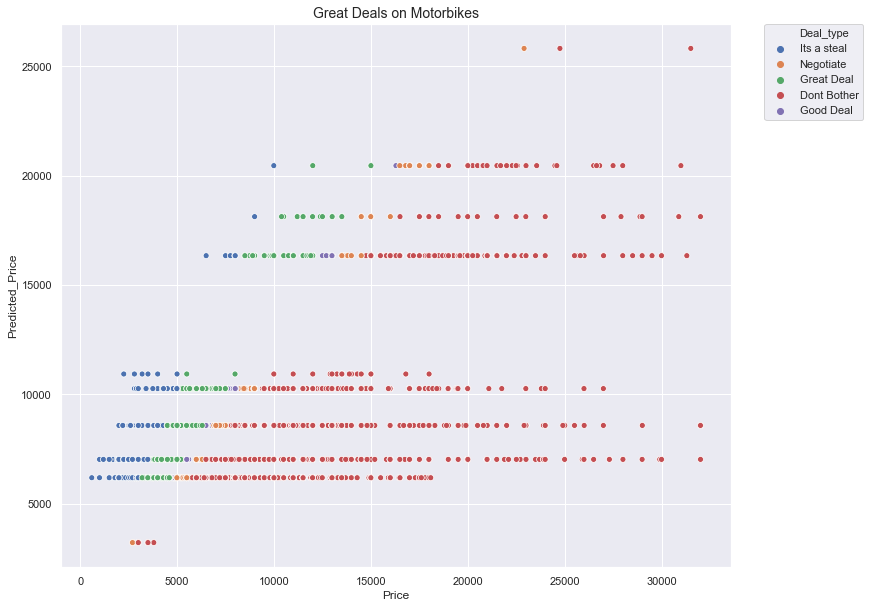

In [14]:
brands = run_pipeline(brand_cols)

Model:  RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
Score:  0.7502978361542754
Feature selection process.
Added feature: Model_Ninja 250r ex250j with adjusted R^2 = 0.0595
Added feature: Model_S 1000 rr with adjusted R^2 = 0.113
Added feature: Model_f3 800 rc with adjusted R^2 = 0.154
Added feature: Model_959 panigale with adjusted R^2 = 0.19
Added feature: Model_Yzf r1m with adjusted R^2 = 0.221
Added feature: Model_Cbr250r with adjusted R^2 = 0.251
Added feature: Model_1199 panigale r abs with adjusted R^2 = 0.28
Added feature: Model_Cbr500ra abs with adjusted R^2 = 0.304
Added feature: Model_Yzf r3 with adjusted R^2 = 0.328
Added feature: Model_Supersport s with adjusted R^2 = 0.347
Added feature: Model_Ninja zx 10r krt abs replica with adjusted R^2 = 0.366
Added feature: Model_Cbr500r with adjusted R^2 = 0.383
Added feature: Model_Ninja 300 abs ex300b with adjusted R^2 = 0.402
Added fea

C:\Users\Beau\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


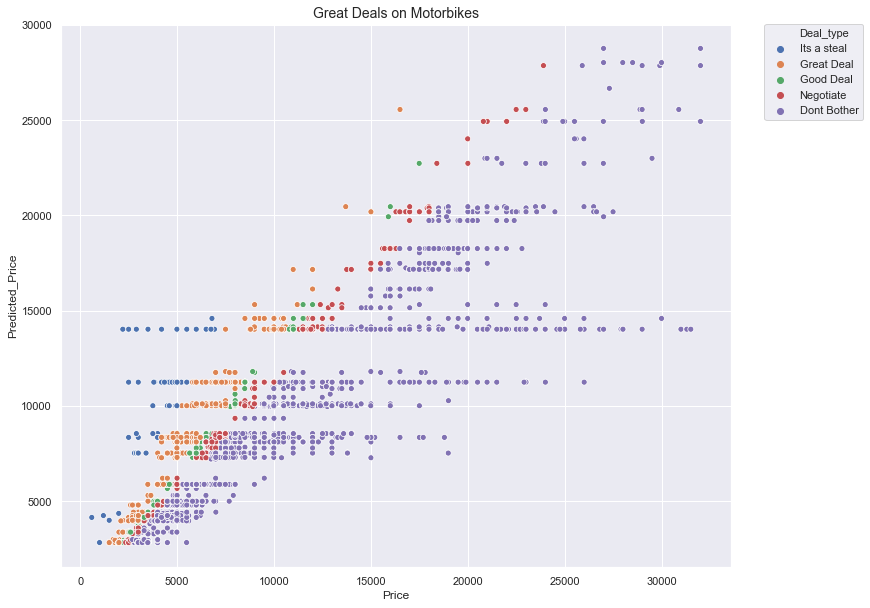

In [15]:
models = run_pipeline(model_cols)

Model:  BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
Score:  0.8796609789944728
Feature selection process.
Added feature: Maximum_Power with adjusted R^2 = 0.74
Added feature: Age with adjusted R^2 = 0.854
Added feature: Swingarm_Type_Single Sided with adjusted R^2 = 0.876
Added feature: Width with adjusted R^2 = 0.881
Added feature: Bike_F4 750 S Road Manual 6sp 750cc with adjusted R^2 = 0.896

Resulting features:
Maximum_Power, Age, Swingarm_Type_Single Sided, Width, Bike_F4 750 S Road Manual 6sp 750cc
Score:  0.8956592452710278


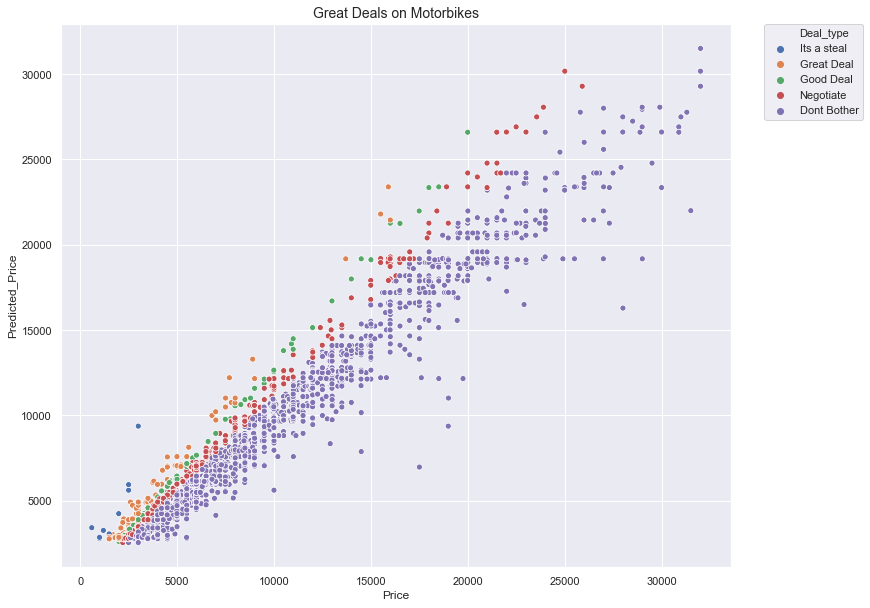

In [16]:
allFeatures = run_pipeline()

In [ ]:
print (len(allFeatures.model['Features']))


In [17]:
# ALL Features
sport = bikeSales()
    
sport.read_data()

In [18]:
sport.add_dummy_variables()
    


In [19]:
features = list(set(sport.df.columns) - set(['Price']))
        
sport.find_best_model(features, sport.df['Price'])
print ('Model: ',sport.model['Model'])
print ('Score: ',sport.model['Score'])

    

Model:  RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
Score:  0.8781836036432233


In [20]:
len(sport.model['Features'])

647

In [ ]:
print ('Feature selection process.')
sport.feature_selection(features)
print ('Score: ',sport.model['Score'])
print ('Features: ',sport.model['Features'])
    

Feature selection process.
Added feature: Maximum_Power with adjusted R^2 = 0.499
Added feature: Traction_Control_Standard with adjusted R^2 = 0.666
Added feature: Kilometers with adjusted R^2 = 0.745
Added feature: Swingarm_Type_Single Sided with adjusted R^2 = 0.777
Added feature: Engine_Size with adjusted R^2 = 0.787
Added feature: Model_Ninja zx 10r krt abs replica with adjusted R^2 = 0.796
Added feature: Colour_none with adjusted R^2 = 0.803
Added feature: Brand_Bimota with adjusted R^2 = 0.809
Added feature: Age with adjusted R^2 = 0.819
Added feature: Model_916 with adjusted R^2 = 0.827
Added feature: Learner_Approved_Yes with adjusted R^2 = 0.833
Added feature: Linked_Braking_System_No with adjusted R^2 = 0.839
Added feature: Model_f3 800 rc with adjusted R^2 = 0.844
Added feature: Bike_1199 Panigale R ABS Road Manual 1198cc with adjusted R^2 = 0.849
Added feature: Bike_F4 RR 1000 Road Manual 1000cc with adjusted R^2 = 0.852
Added feature: Side_Stand_Standard with adjusted R^2 

In [ ]:
sport.fit(sport.df[sport.model['Features']],sport.df['Price'])
    

In [ ]:
predictions = sport.predict(sport.df[sport.model['Features']])
sport.df['Predicted_Price'] = predictions
    

In [ ]:
sport.deal_type()


In [ ]:
sport.plot_deals(x='Price',y='Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')
    

In [ ]:
len(sport_df.columns)

In [ ]:
sport_df = sport.df
sport_df.drop(['Predicted_Price','Price_ratio','Deal_type'],axis=1, inplace=True)
print(len(sport_df.columns))


features = list(set(sport_df.select_dtypes(include='number').columns) - set([target]))
features

In [ ]:
#sport_df = sport.df
#sport_df.drop(['Predicted_Price','Price_ratio','Deal_type'],axis=1, inplace=True)
def adjusted_r2(r2, n, k):
        return 1 - (1-r2)*((n-1)/(n-k-1)) 

    
target = 'Price'
feature_set = list(set(sport_df.select_dtypes(include='number').columns) - set([target]))

model = RidgeCV(cv=5)

X = sport_df[feature_set]
y = sport_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

n = X_train.shape[0]

best_score = 0
best_feature = ''
included = []

# top 10 features
while True:
    changed = False

    for col in feature_set:
        
        model.fit(X_train[included + [col]], y_train)
        r2 = model.score(X_test[included + [col]], y_test)

        k = len(included + [col]) + 1
        score = adjusted_r2(r2,n,k) 

        if (score > best_score):
            best_score = score
            best_feature = col
            changed = True
            

    if changed:
        included.append(best_feature)
        print (f'ADDED: {best_feature}; score: {best_score:.3f}')
        # reset for the next round
        #best_score = 0
        #best_feature = ''
        feature_set = list(set(feature_set) - set(included))
        
    else:
        break
    
    
    
    
print (included)

In [ ]:
feature_set

#len(included)

#Stroke, 
#Age, 
#Trail,  
#Country_of_Origin_UNITED KINGDOM, 
#Model_Yzf r1m, 
#Bike_GSX-R1000R Road Manual 6sp 1000cc, 
#Registration_Expiry_01/11/2018, 
#Carburettor_Carburettor, 
#Registration_Expiry_01/06/2020

In [37]:
model = RidgeCV(cv=5)
model.fit(X_train[included], y_train)
model.score(X_test[included], y_test)

0.9070676541117689

In [43]:
model.fit(sport_df[included],sport_df[target])
predictions = model.predict(sport_df[included])
sport_df['Predicted_Price'] = predictions

In [44]:
sport_df['Price_ratio'] = sport_df['Price'] / sport_df['Predicted_Price']

sport_df['Deal_type'] = 'Dont Bother *'
sport_df['Deal_type'][sport_df['Price_ratio'] < 0.9] = 'Negotiate **'
sport_df['Deal_type'][sport_df['Price_ratio'] < 0.8] = 'Good Deal ***'
sport_df['Deal_type'][sport_df['Price_ratio'] < 0.75] = 'Great Deal ****'        
sport_df['Deal_type'][sport_df['Price_ratio'] < 0.5] = 'Its a steal *****'
        

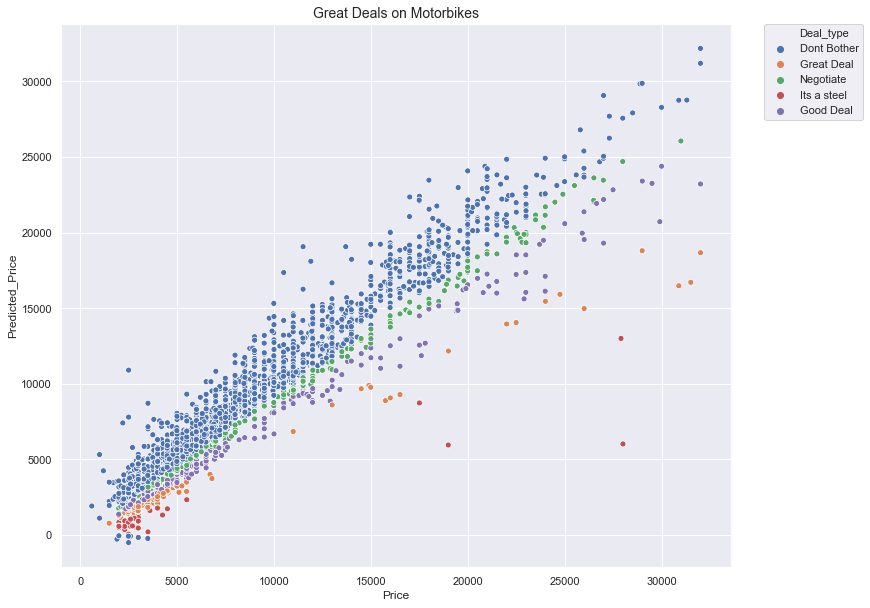

In [47]:
def scatter(data,x,y,hue=None,title='',figsize=(12,10)):
    ax = plt.figure(figsize=figsize)
    sns.scatterplot(x=x,y=y,hue=hue,data=data);
    plt.title(title,fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.ylim(0,40000)

scatter(sport_df,'Price','Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')


In [27]:
sport.df.columns

Index(['Bore', 'Carburettor(s)', 'Compression_Ratio', 'Cylinders',
       'Dry_Weight', 'Engine_Description', 'Front_Brake_Diameter',
       'Front_Suspension_Travel', 'Fuel_Reserve_Capacity',
       'Fuel_Tank_Capacity',
       ...
       'Model_f4 1000 abs', 'Model_f4 1000s corse', 'Model_f4 312 r 1000',
       'Model_f4 312 r 1000 11', 'Model_f4 750 s', 'Model_f4 750 s f4s 11',
       'Model_f4 r', 'Model_f4 rr', 'Model_f4 rr 1000', 'Model_f4ago 1000'],
      dtype='object', length=1647)

In [216]:
bike_cols = [col for col in sport.df.columns if 'Bike' in col]
brand_cols = [col for col in sport.df.columns if 'Brand' in col]
model_cols = [col for col in sport.df.columns if 'Model' in col]
niave_feature = ['Kilometers','Age']


features = [niave_feature, bike_cols, brand_cols, model_cols]

for i, col in enumerate(features):
    
    sport.model = sport.find_best_model(col, sport.df['Price'])
    
    sport.fit(sport.df[niave_feature],sport.df['Price'])
    
    predictions = sport.predict(sport.df[niave_feature])
    sport.df['Predicted_Price_'+str(i)] = predictions

    
    
    

In [217]:
pred_cols = [col for col in sport.df.columns if 'Predicted' in col]
sport.df[pred_cols].head()

,Predicted_Price,Predicted_Price_0,Predicted_Price_1,Predicted_Price_2,Predicted_Price_3
0,5766.422408,5766.422408,5766.422408,5317.638077,5766.422408
1,9793.277150,9793.277150,9793.277150,9997.887675,9793.277150
2,4239.099500,4239.099500,4239.099500,3502.268535,4239.099500
3,5903.430252,5903.430252,5903.430252,4923.078853,5903.430252
4,7352.072148,7352.072148,7352.072148,6921.687257,7352.072148


In [97]:
sport_df[['Price','Predicted_Price','Price_ratio','Deal_type']][sport_df['Price'] > 15000].head(10)

,Price,Predicted_Price,Price_ratio,Deal_type
1127,15200.0,15942.485560,0.953427,Dont Bother
1128,15200.0,14838.217986,1.024382,Dont Bother
1129,15500.0,16299.801669,0.950932,Dont Bother
1130,15500.0,15537.357269,0.997596,Dont Bother
1131,15500.0,15509.065737,0.999415,Dont Bother
1132,15500.0,15844.266557,0.978272,Dont Bother
1133,15500.0,11012.781500,1.407456,Good Deal
1134,15500.0,11697.645542,1.325053,Good Deal
1135,15600.0,17851.471749,0.873878,Dont Bother
1136,15700.0,16723.216950,0.938815,Dont Bother
